In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import dill
import glob, csv
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt') # Download this as this allows you to tokenize words in a string.
lemmatizer = WordNetLemmatizer()


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import re
import string
import seaborn as sns
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Convert CSV to Dataframe

In [ ]:
#convert csv to dataframe
train_dataframe = pd.read_csv("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/mega_train.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_dataframe = pd.read_csv("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/mega_test_v3.csv")

In [ ]:
new_csv = []
skip = True

with open("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_train.csv", "r") as attack_csv:
  content = csv.reader(attack_csv)

  for row in content:
    if skip == True:
      skip = False
      continue

    # print(row[0])
    str_temp = re.findall(r"'(.*?)'|\"(.*?)\"", row[0])
    final_str = []

    for words in str_temp:
      if(words[0] == ""):
        final_str.append(words[1])
      else:
        final_str.append(words[0])
    new_csv.append([" ".join(final_str), row[1]])
    # break

with open("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_train_str.csv", "w") as attack_str:
  writer = csv.writer(attack_str)
  writer.writerow(["text", "Author_num"])

  for article in new_csv:
    writer.writerow(article)

In [ ]:
train_dataframe.head()

,index,text,Author
0,3225,Treasury Secretary Robert Rubin goes to Capito...,AaronPressman
1,744,U.S. banks will be able to significantly incre...,AaronPressman
2,737,Supreme Court justices Wednesday sharply quest...,AaronPressman
3,740,"Fast running out of options, federal credit un...",AaronPressman
4,3241,The U.S. Commerce Department showed an unexpec...,AaronPressman


In [ ]:
test_dataframe.head()

,index,text,Author,hopeful_test
0,8,Britain's Ladbroke Group Plc Monday concluded ...,SimonCowell,1
1,10,Scottish Amicable on Thursday asked for firm o...,SimonCowell,1
2,15,Scottish Amicable's plans to float on the stoc...,SimonCowell,1
3,17,The head of the Securities and Investments Boa...,SimonCowell,1
4,20,Britain's Britannic Assurance declared on Tues...,SimonCowell,1


 Create new column with author number mappings for ML

In [ ]:
# create new col with author number mappings for ML
auth_sort = sorted(train_dataframe['Author'].unique())
dictOfAuthors = { i : auth_sort[i] for i in range(0, len(auth_sort) ) }
swap_dict = {value:key for key, value in dictOfAuthors.items()}
train_dataframe['Author_num'] = train_dataframe['Author'].map(swap_dict)

In [ ]:
# create new col with author number mappings for ML
auth_sort = sorted(test_dataframe['Author'].unique())
dictOfAuthors = { i : auth_sort[i] for i in range(0, len(auth_sort) ) }
swap_dict = {value:key for key, value in dictOfAuthors.items()}
test_dataframe['Author_num'] = test_dataframe['Author'].map(swap_dict)

In [ ]:
train_dataframe.head()

,index,text,Author,Author_num
0,3225,Treasury Secretary Robert Rubin goes to Capito...,AaronPressman,0
1,744,U.S. banks will be able to significantly incre...,AaronPressman,0
2,737,Supreme Court justices Wednesday sharply quest...,AaronPressman,0
3,740,"Fast running out of options, federal credit un...",AaronPressman,0
4,3241,The U.S. Commerce Department showed an unexpec...,AaronPressman,0


In [ ]:
test_dataframe.head()

,index,text,Author,hopeful_test,Author_num
0,8,Britain's Ladbroke Group Plc Monday concluded ...,SimonCowell,1,44
1,10,Scottish Amicable on Thursday asked for firm o...,SimonCowell,1,44
2,15,Scottish Amicable's plans to float on the stoc...,SimonCowell,1,44
3,17,The head of the Securities and Investments Boa...,SimonCowell,1,44
4,20,Britain's Britannic Assurance declared on Tues...,SimonCowell,1,44


In [ ]:
# only left text(article) in dataframe
test_dataframe = test_dataframe.drop(columns='Author')
# train_dataframe = train_dataframe.drop(columns='Author')
# train_dataframe = train_dataframe.drop(columns='index')
test_dataframe = test_dataframe.drop(columns='index')
test_dataframe = test_dataframe.drop(columns='hopeful_test')

In [ ]:
# check out excerpted data
test_dataframe.head()

,text,Author_num
0,Britain's Ladbroke Group Plc Monday concluded ...,44
1,Scottish Amicable on Thursday asked for firm o...,44
2,Scottish Amicable's plans to float on the stoc...,44
3,The head of the Securities and Investments Boa...,44
4,Britain's Britannic Assurance declared on Tues...,44


In [ ]:
train_dataframe.head()

,text,Author_num
0,Treasury Secretary Robert Rubin goes to Capito...,0
1,U.S. banks will be able to significantly incre...,0
2,Supreme Court justices Wednesday sharply quest...,0
3,"Fast running out of options, federal credit un...",0
4,The U.S. Commerce Department showed an unexpec...,0


In [ ]:
list_to_choose_train = train_dataframe.text.apply(lambda x : len(x)) > 0
train_df_article = train_dataframe[list_to_choose_train]

In [ ]:
list_to_choose_test = test_dataframe.text.apply(lambda x : len(x)) > 0
test_df_article = test_dataframe[list_to_choose_test]

In [ ]:
train_df_article.to_csv(r'/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/train.csv', index = False)

In [ ]:
test_df_article.to_csv(r'/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/test_v3.csv', index = False)

To use *torchtext* here, we might need to re-install old version of it.

Here we use torchtext 0.6.0.

In [ ]:
# We have to use old version of torchtext to use data.Field attribute
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [ ]:
!python -m spacy download en_core_web_sm

2023-11-26 15:00:21.400747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 15:00:21.400818: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 15:00:21.400854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 15:00:22.996539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
#import torch
#import spacy
#nlp = spacy.load("en_core_web_sm")
from torchtext import data
TEXT = data.Field(sequential=True, tokenize="spacy", tokenizer_language="en_core_web_sm", lower=True, include_lengths=True) # new tokenizer_language to fit new model
SCORE = data.Field(sequential=False, use_vocab=False)

Utilizing Datafields

In [ ]:
datafields = [("text", TEXT),
              ("Author_num", SCORE)]

train= data.TabularDataset(
    path='/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/train.csv',
    format='csv',fields=datafields,skip_header = True)

val = data.TabularDataset(
    path='/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/test.csv',
    format='csv',fields=datafields,skip_header = True)


# take only partial example
# train_examples = [example for example in train]
# train_subset = train_examples[:1]
# train = data.Dataset(train_subset, fields=datafields)

In [ ]:
ex1 = [['who', 'is', 'threr'], 1]
ex2 = data.Example.fromlist(ex1, fields=datafields)
print(ex2.text)
print(ex2.Author_num)
print(train[0].text)

['who', 'is', 'threr']
1
['treasury', 'secretary', 'robert', 'rubin', 'goes', 'to', 'capitol', 'hill', 'on', 'tuesday', 'to', 'further', 'explain', 'the', 'clinton', 'administration', "'s", 'bank', 'reform', 'plan', ',', 'but', 'lawmakers', 'are', 'likely', 'to', 'focus', 'foremost', 'on', 'what', 'the', 'plan', 'left', 'out', '.', '\n', 'the', 'clinton', 'proposal', ',', 'along', 'with', 'several', 'pending', 'bills', ',', 'would', 'scrap', 'the', '1933', 'glass', '-', 'steagall', 'act', "'s", 'separation', 'of', 'banking', 'from', 'other', 'financial', 'services', '.', '\n', 'on', 'the', 'contentious', 'issue', 'of', 'going', 'further', 'and', 'allowing', 'banks', 'to', 'combine', 'with', 'commercial', 'firms', ',', 'however', ',', 'the', 'administration', 'ducked', '.', ' \n', 'instead', ',', 'the', 'clinton', 'plan', 'unveiled', 'by', 'rubin', 'on', 'may', '21', ',', 'offered', 'two', 'alternatives', 'and', 'left', 'the', 'hard', 'choice', 'to', 'congress', '.', '\n', '"', 'we', 't

In [ ]:
from torchtext import vocab
from torchtext.vocab import GloVe
TEXT.build_vocab(train, val, min_freq = 3, vectors=GloVe(name='6B', dim=100))

.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18682.73it/s]


**Iterators**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device according to hardware support
BATCH_SIZE = 64
train_iterator = data.BucketIterator(
    train,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=True,
    device = device)

val_iterator = data.BucketIterator(
    val,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)


# print(train.examples[0].text)
# print(val_iterator.data()[0].text)

# for batch in val_iterator:
#   c, cl = batch.text
#   print(c[0])
#   break


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib
import pandas as pd
import dill
import random
import torch.optim as optim
import matplotlib.pyplot as plt

**Network Architecture**

In [ ]:
class AuthorClassifier(nn.Module):

    def __init__(self, mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
      super(AuthorClassifier, self).__init__()

      if mode not in ['rnn', 'lstm', 'gru', 'bilstm']:
        raise ValueError("Choose a mode from - rnn / lstm / gru / bilstm")

      self.mode = mode
      self.output_size = output_size
      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.embedding_length = embedding_length
      self.embedding = nn.Embedding(self.vocab_size,self.embedding_length)
      self.embedding.weight = nn.Parameter(word_embeddings,requires_grad = True)  # True to keep gradient



      if self.mode == 'rnn':
        self.network = nn.RNN(self.embedding_length,self.hidden_size)
      elif self.mode == 'lstm':
        self.network = nn.LSTM(self.embedding_length,self.hidden_size)
      elif self.mode == 'gru':
        self.network = nn.GRU(self.embedding_length,self.hidden_size)
      elif self.mode == 'bilstm':
        self.network = nn.LSTM(self.embedding_length,self.hidden_size,bidirectional = True)


      self.fclayer = nn.Linear(self.hidden_size,self.output_size)


    def forward(self, text, text_lengths):
      text_embeddings = self.embedding(text)
      pack_sequence = nn.utils.rnn.pack_padded_sequence(text_embeddings,text_lengths.cpu()) # lengths.cpu() for matching new input format

      if self.mode in ('lstm','bilstm'):
        a,(hidden,cell) = self.network(pack_sequence)
        if self.mode == 'bilstm':
          hidden = hidden[0,:,:]+ hidden[1,:,:]
      else:
        a,hidden = self.network(pack_sequence)
      hidden = hidden.squeeze(0)
      pred = self.fclayer(hidden)
      return pred

**Training and testing models**

In [ ]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay  # new version of plot_confusion_matrix

grad_cache = []
def store_grad(grad):
  grad_cache.append(grad)
  return grad

def train_classifier(model, dataset_iterator, loss_function, optimizer, num_epochs, log = "runs", verbose = False, recurrent = True):
  writer = SummaryWriter(log_dir=log)
  model.train()
  step = 0
  f1score_train = []
  accuracy_train = []
  loss_train = []

  model.embedding.weight.register_hook(store_grad)
  for epoch in range(num_epochs):
    correct = 0
    total = 0
    total_loss = 0
    f1 = 0
    f1_step = 0

    for batch in dataset_iterator:
      comment, comment_lengths = batch.text
      labels = batch.Author_num

      # print(comment.size())
      # print(labels)

      batch_size = len(labels)
      optimizer.zero_grad()
      output = model(comment, comment_lengths).squeeze(0)
      # model.embedding.weight.retain_grad()

      # vocab_list = TEXT.vocab.itos
      # tmp = []
      # for idx in range(64):
      #   tmp.append(vocab_list[comment[0][idx]])

      # print(tmp)

      # reshape when only one article in training set
      if output.size() == torch.Size([50]):
        output = output.view(1, 50)

      loss = loss_function(output, labels.long())
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),0.5)
      optimizer.step()

      pred = torch.max(output.data,1).indices
      f1 += sklearn.metrics.f1_score((labels.cpu()).numpy(), (pred.cpu()).numpy(),average= 'macro')
      correct += (torch.sum(pred == labels)).item()
      total += len(labels)
      total_loss += loss.item()
      f1_step += 1

      if ((step % 100) == 0):
        writer.add_scalar("Loss/train", total_loss/total, step)
        writer.add_scalar("Acc/train", correct/total, step)
        writer.add_scalar("F1 Score/train", f1/f1_step, step)

      step = step+1
    f1score_train.append(f1/f1_step)
    loss_train.append(total_loss/total)
    accuracy_train.append(correct/total)
    print('---Training statistics---',"Epoch: %s Acc: %s Loss: %s"%(epoch+1, correct/total, total_loss/total),'F1 Score:',f1/f1_step,)

  return loss_train,f1score_train,accuracy_train

def evaluate_classifier(model, dataset_iterator, loss_function, recurrent = True):
  model.eval()

  correct = 0
  total = 0
  total_loss = 0
  overall_pred = []
  overall_label = []
  accuracy_test = []
  loss_test = []
  f1_step = 0
  f1 = 0

  for batch in dataset_iterator:
    comment, comment_lengths = batch.text
    labels = batch.Author_num   # tag of author number
    output = model(comment, comment_lengths).squeeze(0)
    # print(output.data)
    # print(len(output.data))
    # prediction will be the values in each row
    # they represent the possibility(weight) of an article which belongs to jth author(in jth row)

    # print(comment[0], comment_lengths)
    # print(model.embedding(comment[0]))
    # print(dataset_iterator.data())
    # print(len(labels))

    # print(len(model.embedding.weight.grad))
    # model.embedding.weight.grad stores the gradient of each word to it's embedding
    # use TEXT.vocab.stoi to generate dictionary to map token: idx, then use idx to get grad by model.embedding.weight.grad[idx]

    # vocab_list = TEXT.vocab.itos
    # tmp = []
    # for idx in range(64):
    #   tmp.append(vocab_list[comment[0][idx]])

    # print(tmp)

    loss = loss_function(output, labels.long()) # .long means .to(torch.int64)
    pred = torch.max(output.data,1).indices
    correct += (torch.sum(pred == labels)).item()
    total += len(labels)
    total_loss += loss.item()
    ap = pred.cpu()
    a = np.asarray(ap)
    labels = labels.cpu()
    b = np.asarray(labels)
    f1_step += 1
    overall_pred.append(a)
    overall_label.append(b)

  overall_p= [val for sublist in overall_pred for val in sublist]
  overall_l = [val for sublist in overall_label for val in sublist]
  f1ss = sklearn.metrics.f1_score(overall_l,overall_p,average= 'macro')
  accuracy_test.append(correct/total)
  loss_test.append(total_loss/total)
  print("Validation statistics: Acc: %s Loss: %s"%(correct/total, total_loss/total),'F1 Score:',f1ss)
  return overall_pred,overall_label,accuracy_test,f1ss,loss_test

Simularity calculation


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

In [ ]:
similarity_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def similarity_cal(sentence1, sentence2):
  # create sentence embedding
  embedding1 = similarity_model([sentence1])[0]
  embedding2 = similarity_model([sentence2])[0]

  # calculate cosine simularity
  cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
  # print("相似度:", cosine_similarity)

  return cosine_similarity

In [ ]:
ok = [2, 3, 1]
print(sorted(ok))
print(ok)

[1, 2, 3]
[2, 3, 1]


Crucial word search and replacement generator

In [ ]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def create_replacement(article_model, embedding_grad, example, influence_rank=5, replacement_rank=5, sim_threshold=0.9):
  # calculate gradient norm for each word's embedding
  grad_norm = torch.norm(embedding_grad, dim=1)
  grad_dict = {}

  for i in range(len(grad_norm)):
    grad_dict[vocab_list[i]] = grad_norm[i]

  grad_dict_sorted = {k: v for k, v in sorted(grad_dict.items(), key=lambda item: item[1], reverse=True)}
  grad_list_sorted = list(grad_dict_sorted.keys())
  to_replace = []

  for choose in grad_list_sorted:
    if influence_rank == 0:
      to_replace = grad_list_sorted
      break

    if choose in example.text:
      to_replace.append(choose)

    if len(to_replace) == influence_rank:
      break


  """
  The part below is aimed to find top k closest words of a certain word.
  We use euclidean distance in word embedding to calculate.
  """
  words_in_article = []
  for info in example.text:   # example.text is the input article
    words_in_article.append(vocab_dict[info])

  words_in_article = torch.tensor(words_in_article, dtype=torch.int64)
  words_in_article = words_in_article.to(device)  # move to same device as model
  output = article_model.embedding(words_in_article)  # get embeddings of words
  np_word_dict = {}

  # create dictionary of word-embedding pair of np.array of embeddings
  for i in range(len(output)):
    li = [float(num) for num in output[i]]
    np_word_dict[vocab_list[words_in_article[i]]] = np.array(li)

  # print("check")

  # calculate closest word by euclidean distance in word embedding
  alternatives = None
  final_modified = example.text.copy()
  cut = False   # decied when to stop modify

  for retired in to_replace:
    try:
      candidates = sorted(np_word_dict.keys(), key=lambda word: spatial.distance.euclidean(np_word_dict[word], np_word_dict[retired]))[1:]  # [0] will always be itself
    except KeyError:  # retired not in np_word_dict embedding table
      continue

    # print(retired)
    sim = 0

    # modified the original article and calculate similarity
    for attempt in candidates:
      modified = final_modified.copy()

      try:
        # print(retired, attempt)
        modified[modified.index(retired)] = attempt
      except ValueError:  # retired not in this article
        continue

      sim = similarity_cal(" ".join(example.text), " ".join(modified))
      if sim > sim_threshold:
        final_modified = modified
        break

      cut = True  # no modification can reach expected similarity

    if cut:
      break

  print(final_modified)
  print(example.text)
  print(similarity_cal(" ".join(example.text), " ".join(final_modified)))
  alternatives = data.Example.fromlist([final_modified, example.Author_num], fields=datafields) if final_modified != example.text else None

  return alternatives

# print top 5 word of gradient norm
# def top_influence_words(k):
#   ret = list(grad_dict_sorted.keys())[:k]
#   return ret

# to_replace = top_influence_words(5)

Training for word replacement

This part is used for attacking.

In [ ]:
#LSTM based
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))


output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'lstm'

# print(len(word_embeddings), len(TEXT.vocab.itos))
# print(len(word_embeddings[0]))
# print(len(TEXT.vocab))
vocab_dict = TEXT.vocab.stoi
vocab_list = TEXT.vocab.itos
# print(vocab_dict["thursday"])


log_dir = 'runs/lstm1'
attack_list = []


for author in range(50):  # take val as test here
  single_author_list = []

  for example in val:
    if int(example.Author_num) == author:
      single_author_list.append(example)

  print(len(single_author_list))
  test_data = data.Dataset(single_author_list, fields=datafields)
  test_iterator = data.BucketIterator(test_data, batch_size = BATCH_SIZE, sort=False, sort_key = lambda x: len(x.text), sort_within_batch = True, repeat=False, shuffle=True, device = device)
  art_model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
  art_model = art_model.to(device)

  # simple train for testing article to get gradient
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(art_model.parameters(), lr=1e-2)
  temp_loss,temp_f1,temp_accs = train_classifier(art_model, test_iterator, loss_function, optimizer, log = log_dir, num_epochs = 5)

  for example in single_author_list:
    attack_list.append(create_replacement(art_model, art_model.embedding.weight.grad, example, influence_rank=0, sim_threshold=0.98))



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(attack_list[0])
print(attack_list[0].text)

['treasury', 'secretary', 'robert', 'rubin', 'goes', 'would', 'capitol', 'hill', 'the', 'tuesday', 'to', 'however', 'explain', 'one', 'clinton', 'administration', 'their', 'bank', 'reform', 'proposal', ',', 'so', 'lawmakers', 'have', 'could', 'to', 'focus', 'foremost', 'on', 'what', 'the', 'plan', 'left', 'so', 'but', '--202', 'the', 'clinton', 'proposal', ',', 'along', 'with', 'other', 'pending', 'bills', ',', 'would', 'scrap', 'the', '1933', 'glass', 'over', 'steagall', 'act', "'s", 'separation', 'the', 'financial', 'came', 'other', 'banking', 'allow', '.', '\n', 'on', 'the', 'contentious', 'legal', 'of', 'so', 'further', 'and', 'allowing', 'banks', 'to', 'combine', 'with', 'small', 'companies', ',', 'but', ',', 'the', 'administration', 'ducked', '.', '--202', 'instead', ',', 'the', 'clinton', 'plan', 'unveiled', 'with', 'rubin', 'on', 'likely', '21', ',', 'offered', 'one', 'alternatives', 'and', 'left', 'the', 'hard', 'choice', 'to', 'lawmakers', '.', '\n', 'referred', 'we', 'think'

In [ ]:
# transform attack articles into iterator
attack = data.Dataset(attack_list, fields=datafields)

attack_iterator = data.BucketIterator(
    attack,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)

output attack list to csv

In [ ]:
attack_dict = {
    "text": [" ".join(ex.text) for ex in attack_list],
    "Author_num": [ex.Author_num for ex in attack_list]
}

att_df = pd.DataFrame(attack_dict)
att_df.to_csv("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_of_val.csv")

Import attack article from csv

In [ ]:
attack = data.TabularDataset(
    path='/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_train_str.csv',
    format='csv',fields=datafields,skip_header = True)

# select partial dataset
attack_tmp = []
for i in range(50):
  for j in range(10):
    attack_tmp.append(attack[80 * i + j])

print(len(attack_tmp))
attack = data.Dataset(attack_tmp, fields=datafields)

attack_iterator = data.BucketIterator(
    attack,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)

500


In [ ]:
output_csv_strings = []

for articles in attack_iterator.data():
  tmp = articles.text
  flit_tmp = filter(lambda x: (x != "[" and x != "'" and x != "]"), tmp)
  tmp = " ".join(list(flit_tmp))
  print(tmp)
  output_csv_strings.append(data.Example.fromlist([tmp, articles.Author_num], fields=datafields))
  break

treasury , secretary , robert , rubin , goes , would , capitol , hill , the , tuesday , to , however , explain , one , clinton , administration , their , bank , reform , proposal , , , so , lawmakers , have , could , to , focus , foremost , on , what , the , plan , left , so , but , --202 , the , clinton , proposal , , , along , with , other , pending , bills , , , would , scrap , the , 1933 , glass , over , steagall , act , " 's " , separation , the , financial , came , other , banking , allow , . , \n , on , the , contentious , legal , of , so , further , and , allowing , banks , to , combine , with , small , companies , , , but , , , the , administration , ducked , . , --202 , instead , , , the , clinton , plan , unveiled , with , rubin , on , likely , 21 , , , offered , one , alternatives , and , left , the , hard , choice , to , lawmakers , . , \n , referred , we , think , the , issue , needs , to , would , further , debated , by , congress , , , " , the , secretary , , , one , bu

In [ ]:
print(attack_iterator.data()[0].text)
print(attack_iterator.data()[0].Author_num)

['treasury', 'secretary', 'robert', 'rubin', 'goes', 'would', 'capitol', 'hill', 'the', 'tuesday', 'to', 'however', 'explain', 'one', 'clinton', 'administration', 'their', 'bank', 'reform', 'proposal', ',', 'so', 'lawmakers', 'have', 'could', 'to', 'focus', 'foremost', 'on', 'what', 'the', 'plan', 'left', 'so', 'but', '--202', 'the', 'clinton', 'proposal', ',', 'along', 'with', 'other', 'pending', 'bills', ',', 'would', 'scrap', 'the', '1933', 'glass', 'over', 'steagall', 'act', "'s", 'separation', 'the', 'financial', 'came', 'other', 'banking', 'allow', '.', '\\n', 'on', 'the', 'contentious', 'legal', 'of', 'so', 'further', 'and', 'allowing', 'banks', 'to', 'combine', 'with', 'small', 'companies', ',', 'but', ',', 'the', 'administration', 'ducked', '.', '--202', 'instead', ',', 'the', 'clinton', 'plan', 'unveiled', 'with', 'rubin', 'on', 'likely', '21', ',', 'offered', 'one', 'alternatives', 'and', 'left', 'the', 'hard', 'choice', 'to', 'lawmakers', '.', '\\n', 'referred', 'we', 'thin

Original model training and evaluation

LSTM

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

378

---Training statistics--- Epoch: 1 Acc: 0.15075 Loss: 0.050307738363742825 F1 Score: 0.10608317796272011
Validation statistics: Acc: 0.244 Loss: 0.04265126752853394 F1 Score: 0.23148416605326527
---Training statistics--- Epoch: 1 Acc: 0.30775 Loss: 0.036444210320711136 F1 Score: 0.22565951630160924
Validation statistics: Acc: 0.398 Loss: 0.03113528048992157 F1 Score: 0.37160691640803245
---Training statistics--- Epoch: 1 Acc: 0.48525 Loss: 0.024443851113319398 F1 Score: 0.3772695876474063
Validation statistics: Acc: 0.612 Loss: 0.019014367699623107 F1 Score: 0.5995173493479853
---Training statistics--- Epoch: 1 Acc: 0.6895 Loss: 0.014420553475618363 F1 Score: 0.5782493797127088
Validation statistics: Acc: 0.782 Loss: 0.01193081945180893 F1 Score: 0.7770214675280444
---Training statistics--- Epoch: 1 Acc: 0.84525 Loss: 0.007359632536768914 F1 Score: 0.7636691890026537
Validation statistics: Acc: 0.855 Loss: 0.00834066817164421 F1 Score: 0.8553397885817533
---Training statistics--- Epoch

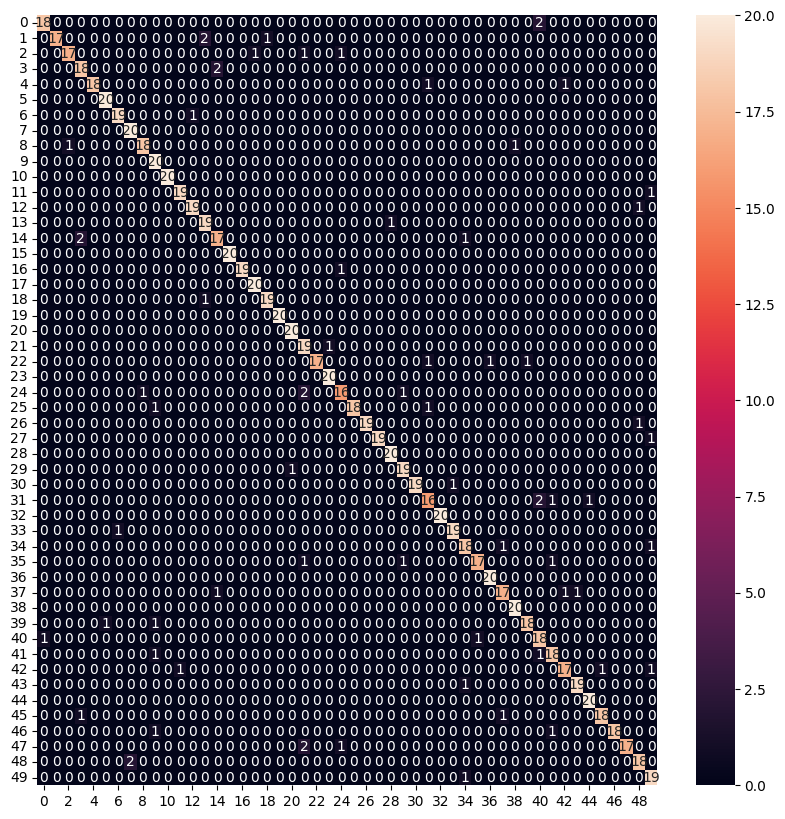

In [ ]:
#LSTM
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))


output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'lstm'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model = model.to(device)
# print(len(word_embeddings), len(TEXT.vocab.itos))
# print(len(word_embeddings[0]))
# print(len(TEXT.vocab))
# vocab_dict = TEXT.vocab.stoi
# vocab_list = TEXT.vocab.itos
# print(vocab_dict["thursday"])


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/lstm1'
final_acc_train_lstm  = []
final_loss_train_lstm = []
final_loss_test_lstm = []
final_acc_test_lstm = []
final_f1score_train_lstm = []
final_f1score_test_lstm = []


for multi in range(20):
  loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
  overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
  final_acc_train_lstm.append(accs[0])
  final_acc_test_lstm.append(accs_test[0])
  final_f1score_train_lstm.append(f1score[0])
  final_f1score_test_lstm.append(f1ss)
  final_loss_train_lstm.append(loss_train[0])
  final_loss_test_lstm.append(loss_test[0])

# overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, attack_iterator, loss_function)
torch.save(model.state_dict(), "/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/baseline.pt")

cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

In [ ]:
print(auth_sort[6])

DarrenSchuettler


In [ ]:
"""
This part is to find top 5 closest words of a certain word.
We use euclidean distance in word embedding to calculate.
"""
words_in_article = []
for info in train.examples[0].text:   # train.examples[0].text is the input article
  words_in_article.append(vocab_dict[info])

words_in_article = torch.tensor(words_in_article, dtype=torch.int64)
output = model.embedding(words_in_article)
np_word_dict = {}

# create dictionary of word-embedding pair of np.array of embeddings
for i in range(len(output)):
  # print(tmp[i])
  # print(vocab_list[tmp[i]])
  # print(output[i])
  li = [float(num) for num in output[i]]
  # print(li, len(li))
  np_word_dict[vocab_list[words_in_article[i]]] = np.array(li)

# print(np_word_dict)

In [ ]:
# calculate closest word by euclidean distance in word embedding
def find_closest_embeddings(embedding):
    return sorted(np_word_dict.keys(), key=lambda word: spatial.distance.euclidean(np_word_dict[word], embedding))

alternatives = []

for retired in to_replace:
  alternatives.append(find_closest_embeddings(np_word_dict[retired])[1:6])  # [1:6] is because [0] will always be itself

print(alternatives)

[['(', '.', ',', 'is', 'also'], ['last', 'one', 'over', ',', 'with'], ['<unk>', '\n', ' \n', 'exception', '898'], [')', ',', '.', 'or', 'from'], ['\n', '8312', '<unk>', ' \n', 'respectively']]


GRU

In [ ]:
#GRU
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))



output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'gru'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model = model.to(device)


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/gru'
final_acc_train_gru  = []
final_acc_test_gru = []
final_f1score_train_gru = []
final_f1score_test_gru = []
final_loss_train_gru = []
final_loss_test_gru = []

for multi in range(20):
  loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
  overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
  final_acc_train_gru.append(accs[0])
  final_loss_train_gru.append(loss_train[0])
  final_acc_test_gru.append(accs_test[0])
  final_f1score_train_gru.append(f1score[0])
  final_f1score_test_gru.append(f1ss)
  final_loss_test_gru.append(loss_test[0])


cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

BiLSTM

In [ ]:
#bilstm
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))



output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'bilstm'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model = model.to(device)


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/bilstm'
final_acc_train_bilstm  = []
final_acc_test_bilstm = []
final_f1score_train_bilstm = []
final_f1score_test_bilstm = []
final_loss_train_bilstm = []
final_loss_test_bilstm = []

for multi in range(20):
  loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
  overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
  final_acc_train_bilstm.append(accs[0])
  final_loss_train_bilstm.append(loss_train[0])
  final_acc_test_bilstm.append(accs_test[0])
  final_f1score_train_bilstm.append(f1score[0])
  final_f1score_test_bilstm.append(f1ss)
  final_loss_test_bilstm.append(loss_test[0])


cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

Plot - Accuracy

In [ ]:
#Plot - accuracy
import plotly.graph_objects as go
fig_accuracy = go.Figure()

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training accuracy lstm'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing accuracy lstm'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training accuracy gru'))
fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_gru,
    connectgaps=True, marker_color = 'rgba(0, 255, 0, 0.9)', name = 'Testing accuracy gru'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training accuracy bilstm'))
fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_bilstm, connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)',
    name='Test accuracy bilstm'))

fig_accuracy.show()

Loss Plots

In [ ]:
#Loss Plots
import plotly.graph_objects as go
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training Loss lstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing Loss lstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training Loss gru'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_gru,
    connectgaps=True, marker_color='rgba(0, 255, 0, 0.9)', name = 'Testing Loss gru'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training Loss bilstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)', name = 'Testing Loss bilstm'))

fig_loss.show()

F1 Score plots

In [ ]:
#Plot - f1score
import plotly.graph_objects as go
fig_f1score = go.Figure()

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training f1score lstm'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing f1score lstm'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training f1score gru'))
fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_gru,
    connectgaps=True, marker_color = 'rgba(0, 255, 0, 0.9)', name = 'Testing f1score gru'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training f1score bilstm'))
fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_bilstm, connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)',
    name='Test f1score bilstm'))

fig_f1score.show()